## Imports

In [21]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import os
import joblib

import tensorflow as tf
import re
import random
import tf_keras
from tf_keras.callbacks import EarlyStopping  # Use tf.keras.callbacks
import kagglehub
import zipfile
from transformers import TFAutoModel
import shutil
from datetime import timedelta
try:
  import mplfinance as mpf
except:
  !pip install mplfinance
  import mplfinance as mpf
import io
from PIL import Image
from datetime import timedelta

## Downloading the data (Model Never Seen)

In [45]:
def download_and_extract_data(filename="output_latest", filename_output="output"):
    """
    Downloads, extracts, and deletes a zip file if it doesn't already exist.

    Args:
        filename: The name of the zip file to download.
        filename_output: The name of the folder to extract the contents to.
    """
    if not os.path.exists(filename_output):
        try:
            # Download the .zip file
            print(f"Downloading '{filename}'...")
            # Get the actual downloaded file path
            downloaded_file_path = kagglehub.dataset_download("sulimantadros/gbpaud-latest-data-17")

            # Rename if necessary (if kagglehub returns a different name)
            if downloaded_file_path != filename:
                os.rename(downloaded_file_path, filename)
                print(f"Renamed downloaded file to '{filename}'")

        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print(f"File '{filename_output}' already exists. Skipping download and extraction.")

download_and_extract_data(filename="output_latest.zip", filename_output="output")

100%|██████████| 2.11M/2.11M [00:01<00:00, 1.90MB/s]

Extracting files...


An error occurred: [Errno 39] Directory not empty: '/root/.cache/kagglehub/datasets/sulimantadros/gbpaud-latest-data-17/versions/1' -> 'output_latest.zip'


## Download and load the data it was trained on to get variables

In [44]:
def download_and_extract_data_1(filename="output_latest", filename_output="output"):
    """
    Downloads, extracts, and deletes a zip file if it doesn't already exist.

    Args:
        filename: The name of the zip file to download.
        filename_output: The name of the folder to extract the contents to.
    """
    if not os.path.exists(filename_output):
        try:
            # Download the .zip file
            print(f"Downloading '{filename}'...")
            # Get the actual downloaded file path
            downloaded_file_path = kagglehub.dataset_download("sulimantadros/updated-logic-5-minute-forex-1000-datapoints")

            # Rename if necessary (if kagglehub returns a different name)
            if downloaded_file_path != filename:
                os.rename(downloaded_file_path, filename)
                print(f"Renamed downloaded file to '{filename}'")

        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print(f"File '{filename_output}' already exists. Skipping download and extraction.")

download_and_extract_data_1(filename="output_latest_1.zip", filename_output="output")

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Directories
original_train_dir = '/content/output_latest_1.zip/output_updated_logic_5_minute_forex_data/output_hourly_price_action_patterns_training_and_validation/train'
original_valid_dir = '/content/output_latest_1.zip/output_updated_logic_5_minute_forex_data/output_hourly_price_action_patterns_training_and_validation/validation'
original_test_dir = '/content/output_latest_1.zip/output_updated_logic_5_minute_forex_data/output_hourly_price_action_patterns_testing/test'

# Create balanced test dataset
test_ds = tf_keras.utils.image_dataset_from_directory(
    directory=original_test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)

class_names = test_ds.class_names
file_paths = test_ds.file_paths

Renamed downloaded file to 'output_latest_1.zip'
Found 3670 files belonging to 3 classes.


## Building the machine learning model

In [23]:
def count_parameters(model, print_output=True):
  """
  Counts the number of trainable, non-trainable and total parameters of a given model.
  """
  trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.trainable_weights])
  non_trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.non_trainable_weights])
  total_parameters = trainable_parameters + non_trainable_parameters
  if print_output:
    print(f"Model {model.name} parameter counts:")
    print(f"Total parameters: {total_parameters}")
    print(f"Trainable parameters: {trainable_parameters}")
    print(f"Non-trainable parameters: {non_trainable_parameters}")
  else:
    return total_parameters, trainable_parameters, non_trainable_parameters

In [24]:
def create_model(include_top: bool = False,
                 num_classes: int = 1000,
                 input_shape: tuple[int, int, int] = (224, 224, 3),
                 include_preprocessing: bool = True,
                 trainable: bool = False,
                 dropout: float = 0.2,
                 activation: str = "softmax",
                 base_model: tf_keras.Model = None,
                 model_name: str = "model") -> tf_keras.Model:
  """
  Create an EfficientNetV2 B0 feature extractor model with a custom classifier layer.

  Args:
      include_top (bool, optional): Whether to include the top (classifier) layers of the model.
      num_classes (int, optional): Number of output classes for the classifier layer.
      input_shape (tuple[int, int, int], optional): Input shape for the model's images (height, width, channels).
      include_preprocessing (bool, optional): Whether to include preprocessing layers for image normalization.
      trainable (bool, optional): Whether to make the base model trainable.
      dropout (float, optional): Dropout rate for the global average pooling layer.
      activation (str, optional): Activation function for the output layer.
      model_name (str, optional): Name for the created model.

  Returns:
      tf.keras.Model: A TensorFlow Keras model with the specified configuration.
  """
  if base_model is None:
    print('Base Model is None please enter the based model')
    return None

  if activation == "softmax":
    activation = tf_keras.activations.softmax
  elif activation == "sigmoid":
    activation = tf_keras.activations.sigmoid

  # Freeze the base model (if necessary)
  base_model.trainable = trainable

  # Create input layer
  inputs = tf_keras.Input(shape=input_shape, name="input_layer")

  # Create model backbone (middle/hidden layers)
  x = base_model(inputs, training=trainable)

  # Create output layer (also known as "classifier" layer)
  outputs = tf_keras.layers.Dense(
      units=num_classes,
      activation=activation,
      name="output_layer"
  )(x)

  # Connect input and output layer
  model = tf_keras.Model(inputs=inputs, outputs=outputs, name=model_name)

  return model

## Loading the machine learning model

In [46]:
# Download the model from Kaggle
model_0_loaded_path = kagglehub.model_download("sulimantadros/updated_logic_5_minute_forex_convnextxlarge_88/tensorFlow2/default")

# Move the downloaded directory to the current directory
destination_dir = "./model_0"
if not os.path.exists(destination_dir):
    shutil.move(model_0_loaded_path, destination_dir)

# Full path to the .keras model file
# Parameters
model_0_file = os.path.join(destination_dir, "1", "model_0.keras")
include_top = False
input_shape = (224, 224, 3)
include_preprocessing = True

# 1. Create a model
base_model = tf_keras.applications.ConvNeXtXLarge(
    include_top=include_top,
    weights="imagenet",
    input_shape=input_shape,
    include_preprocessing=include_preprocessing,
    pooling="max"  # Can use this instead of adding tf.keras.layers.MaxPooling2D() to the model
)
model_0_loaded_kaggle = create_model(num_classes=len(class_names), trainable=False, base_model=base_model)

# 2. Compile the model
model_0_loaded_kaggle.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.001),
                loss=tf_keras.losses.CategoricalCrossentropy(from_logits=False),  # use from_logits=False if using an activation function in final layer
                metrics=["accuracy"])

## Setting up the backtest and getting the signals from model



In [56]:
# Path to the folder containing CSV files
data_folder = "/content/output_latest.zip/data"

# Initialize results
results = []
print('Starting Loop')

# Iterate through each CSV file in the folder
for file_name in os.listdir(data_folder):
    if file_name.endswith(".csv"):
        # Extract symbol and time from the file name
        symbol, timestamp = file_name.split("_")
        timestamp = timestamp.replace(".csv", "")

        # Load the CSV file
        file_path = os.path.join(data_folder, file_name)
        df = pd.read_csv(file_path)

        # Ensure the 'time' column is a datetime object
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)

        # Select the first 12 data points for the graph
        prediction_window = df.iloc[-17:-5]
        if len(prediction_window) < 12:
            print(f"File {file_name} has insufficient data. Skipping.")
            continue

        # Generate the graph for the first 12 data points
        df_chart = prediction_window[['open', 'high', 'low', 'close']].apply(pd.to_numeric, errors='coerce').dropna()
        fig, ax = plt.subplots()
        mpf.plot(df_chart, type='candle', style='charles', ax=ax)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        # Save the image to an in-memory buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=100, bbox_inches='tight', pad_inches=0)
        buf.seek(0)  # Reset buffer position
        plt.close()

        # Open the image using PIL and resize it to 224x224
        img = Image.open(buf).convert("RGB")
        img_resized = img.resize((224, 224))

        # Display the resized image using matplotlib
        #plt.figure(figsize=(4, 4))  # Set the figure size (optional)
        #plt.imshow(img_resized)
        #plt.axis('off')  # Turn off axes
        #plt.show();

        # Convert the resized image to a NumPy array
        custom_image_tensor = tf.keras.utils.img_to_array(img_resized)

        # Add a batch dimension to the target tensor (e.g., (224, 224, 3) -> (1, 224, 224, 3))
        custom_image_tensor = tf.expand_dims(custom_image_tensor, axis=0)

        # Normalize the image to [0, 1] range if your model expects normalized inputs
        custom_image_tensor = custom_image_tensor / 255.0

        # Make a prediction with the target model
        pred_probs = model_0_loaded_kaggle.predict(custom_image_tensor, verbose=0)

        # Decode the predicted class
        pred_class = class_names[tf.argmax(pred_probs, axis=-1).numpy()[0]]
        #print(f"Predicted class {pred_class} with pred prob {pred_probs}")

        # Record the result with the 12th candle's time and predicted class
        results.append({
            "symbol": symbol,
            "time": prediction_window.index[-1],  # Time of the 12th candle
            "predicted_class": pred_class
        })

        # Cleanup memory
        buf.close()
        del img
        del img_resized

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file for further analysis
output_file = "/content/model_predictions.csv"
results_df.to_csv(output_file, index=False)

print("Results saved to", output_file)

Starting Loop
Results saved to /content/model_predictions.csv


In [58]:
# Count occurrences of each predicted_class
class_counts = results_df['predicted_class'].value_counts()

# Print the counts
print(class_counts)

# Specifically count 'bullish_breakout' and 'bearish_breakout'
bullish_count = class_counts.get('bullish_breakout', 0)
bearish_count = class_counts.get('bearish_breakout', 0)

print(f"Number of 'bullish_breakout': {bullish_count}")
print(f"Number of 'bearish_breakout': {bearish_count}")

predicted_class
no_breakout         4071
bearish_breakout      42
Name: count, dtype: int64
Number of 'bullish_breakout': 0
Number of 'bearish_breakout': 42


In [65]:
# Paths
data_folder = "/content/output_latest.zip/data"
output_csv = "/content/predicted_classes_files.csv"

# Filter results_df for 'bullish_breakout' or 'bearish_breakout'
filtered_results = results_df[
    results_df['predicted_class'].isin(['bullish_breakout', 'bearish_breakout'])
]

# Initialize a list to store the results
matched_files = []
total_results = len(filtered_results)  # Total number of results to find

# Iterate through each filtered row
for _, row in filtered_results.iterrows():
    target_symbol = row['symbol']
    target_time = row['time']
    predicted_class = row['predicted_class']  # Get the predicted_class from results_df

    # Iterate through all CSV files in the data folder
    for file_name in os.listdir(data_folder):
        if file_name.endswith(".csv"):
            # Extract symbol from file name
            file_symbol, _ = file_name.split("_", 1)
            if file_symbol != target_symbol:
                continue  # Skip files that don't match the symbol

            # Load the CSV file
            file_path = os.path.join(data_folder, file_name)
            df = pd.read_csv(file_path)

            # Ensure 'time' column is a datetime object
            df['time'] = pd.to_datetime(df['time'])

            # Check if the target_time exists in the file
            if target_time in df['time'].values:
                # Add the matched details to the list, including predicted_class
                matched_files.append({
                    'pair': target_symbol,
                    'time': target_time,
                    'predicted_class': predicted_class,
                    'filename': file_path
                })

                print(f"FOUND A MATCH: Matched {len(matched_files)} out of {total_results}")

                # Stop searching if all results are found
                if len(matched_files) == total_results:
                    print("ALL MATCHES FOUND")
                    break

print("FINISHED")

# Convert the matched files list to a DataFrame
matched_files_df = pd.DataFrame(matched_files)

# Sort the DataFrame by the 'time' column
matched_files_df['time'] = pd.to_datetime(matched_files_df['time'])
matched_files_df = matched_files_df.sort_values(by='time', ascending=True)

# Save the sorted results to a CSV
matched_files_df.to_csv(output_csv, index=False)

print(f"Results saved to {output_csv}")

FOUND A MATCH: Matched 1 out of 42
FOUND A MATCH: Matched 2 out of 42
FOUND A MATCH: Matched 3 out of 42
FOUND A MATCH: Matched 4 out of 42
FOUND A MATCH: Matched 5 out of 42
FOUND A MATCH: Matched 6 out of 42
FOUND A MATCH: Matched 7 out of 42
FOUND A MATCH: Matched 8 out of 42
FOUND A MATCH: Matched 9 out of 42
FOUND A MATCH: Matched 10 out of 42
FOUND A MATCH: Matched 11 out of 42
FOUND A MATCH: Matched 12 out of 42
FOUND A MATCH: Matched 13 out of 42
FOUND A MATCH: Matched 14 out of 42
FOUND A MATCH: Matched 15 out of 42
FOUND A MATCH: Matched 16 out of 42
FOUND A MATCH: Matched 17 out of 42
FOUND A MATCH: Matched 18 out of 42
FOUND A MATCH: Matched 19 out of 42
FOUND A MATCH: Matched 20 out of 42
FOUND A MATCH: Matched 21 out of 42
FOUND A MATCH: Matched 22 out of 42
FOUND A MATCH: Matched 23 out of 42
FOUND A MATCH: Matched 24 out of 42
FOUND A MATCH: Matched 25 out of 42
FOUND A MATCH: Matched 26 out of 42
FOUND A MATCH: Matched 27 out of 42
FOUND A MATCH: Matched 28 out of 42
F

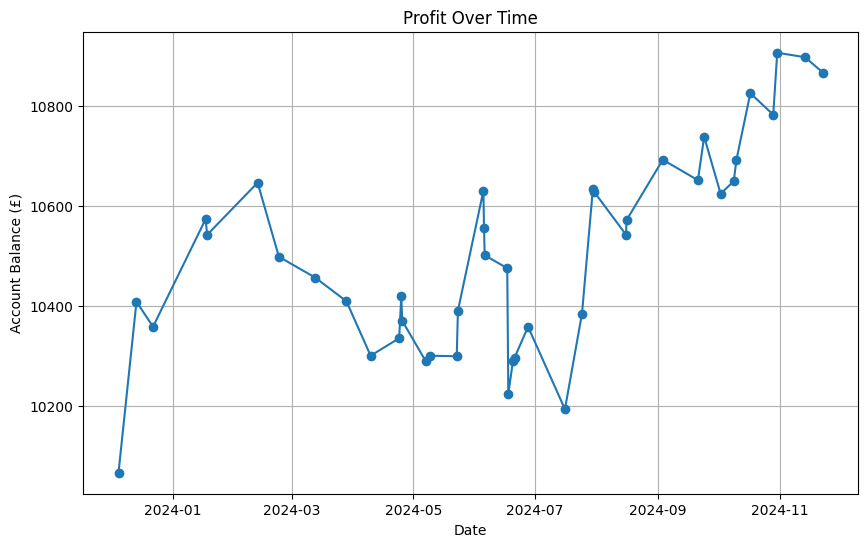

Total Profit: £867.00


In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the matched files DataFrame
matched_files_df = pd.read_csv("/content/predicted_classes_files.csv")

# Initialize starting capital and variables
starting_balance = 10000
current_balance = starting_balance
profits = []  # To store profit over time
profit_dates = []  # To store corresponding dates

# Process each row in the matched files
for _, row in matched_files_df.iterrows():
    file_path = row['filename']
    target_time = pd.to_datetime(row['time'])
    predicted_class = row['predicted_class']

    # Load the CSV file
    df = pd.read_csv(file_path)
    df['time'] = pd.to_datetime(df['time'])

    # Ensure target_time exists in the file
    if target_time not in df['time'].values:
        print(f"Time {target_time} not found in {file_path}. Skipping.")
        continue

    # Get the open price of the target_time
    entry_row = df[df['time'] == target_time]
    entry_price = entry_row['close'].values[0]  # We enter at the close of the target_time

    # Get the close price of the last candle
    exit_price = df['close'].iloc[-1]  # We exit at the last candle close

    # Calculate profit or loss
    if predicted_class == "bullish_breakout":
        # Buy at entry price, sell at exit price
        profit = (exit_price - entry_price) * 100000  # Assuming a position size of 1 lot (100,000 units)
    elif predicted_class == "bearish_breakout":
        # Sell at entry price, buy at exit price
        profit = (entry_price - exit_price) * 100000  # Assuming a position size of 1 lot (100,000 units)
    else:
        continue  # Skip if the predicted_class is not bullish_breakout or bearish_breakout

    # Update balance
    current_balance += profit

    # Store the profit and date for graphing
    profits.append(current_balance)
    profit_dates.append(target_time)

# Plot the profit over time
plt.figure(figsize=(10, 6))
plt.plot(profit_dates, profits, marker='o')
plt.title("Profit Over Time for GBPAUD")
plt.xlabel("Date")
plt.ylabel("Account Balance (£)")
plt.grid()
plt.show()

# Print the final total profit
total_profit = current_balance - starting_balance
print(f"Total Profit: £{total_profit:.2f}")
